# ENV717 L19 - TRANSMISSION-CONSTRAINED ONE-PERIOD ECONOMIC-DISPATCH 

###### Data from Handout Lesson 16 - 17
##### Finds the Economic Dispatch in a network of three buses, for one time period
##### Power Fow is constrainted with KVL around the loop and bus power-balance equations
##### This model is equivalent to the one implemented in Excel-Solver during L18

In [84]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
opt = SolverFactory('cplex') #The CPLEX license is free for students - In Colab you can use CBC

In [85]:
#Read data
df_genData=pd.read_excel(io="EDOnePeriodData.xlsx",sheet_name="GeneratorsData",skiprows=1) #read data from generators tab and skip the first row
df_loadsData=pd.read_excel(io="EDOnePeriodData.xlsx",sheet_name="LoadsData",skiprows=1) #read data from loads tab and skip the first row
df_linesData=pd.read_excel(io="EDOnePeriodData.xlsx",sheet_name="LinesData",skiprows=1) #read data from demand tab and skip the first row

In [86]:
#define the size of the sets
NumGens=len(df_genData)
NumNodes=len(df_loadsData)
NumLines=len(df_linesData)
#T=len(df_demandData)
print("We read data for", NumGens, "power generating units")
print("We read data for", NumNodes, "nodes")
print("We read data for", NumLines, "transmission lines")

We read data for 4 power generating units
We read data for 3 nodes
We read data for 3 transmission lines


In [87]:
#Define Indexes
G=np.array([g for g in range(0,NumGens)]) 
N=np.array([n for n in range(0,NumNodes)])
L=np.array([l for l in range(0,NumLines)])

In [88]:
df_genData.columns

Index(['GenName', 'Node', 'FixedCost', 'SDCost', 'SUCost', 'VarCost', 'MaxGen',
       'MinGen', 'RampDown', 'RampSD', 'RampSU', 'RampUp', 'MinUpTime',
       'MinDownTime', 'ReqUp', 'ReqDown', 'InitialStatus', 'InitialGen'],
      dtype='object')

In [89]:
##Declare the generator's parameters and assign them the data we read before
VarCost=df_genData.loc[:,'VarCost'].to_numpy()
PMax=df_genData.loc[:,'MaxGen'].to_numpy()
PMin=df_genData.loc[:,'MinGen'].to_numpy()
GenNode=df_genData.loc[:,'Node'].to_numpy()

In [90]:
df_linesData.columns  #In the data we defined 3 lines as: L1-2, L2-3, and L3-1. We could have defined them in other way, but this is convenient for the KVL equation

Index(['LineName', 'NodeFrom', 'NodeTo', 'Reactance', 'Capacity'], dtype='object')

In [91]:
##Declare the transmission lines' parameters and assign them the data we read before
NodeFrom=df_linesData.loc[:,'NodeFrom'].to_numpy()
NodeTo=df_linesData.loc[:,'NodeTo'].to_numpy()
LineReactance=df_linesData.loc[:,'Reactance'].to_numpy()
LineCapacity=df_linesData.loc[:,'Capacity'].to_numpy()

In [92]:
df_loadsData.columns

Index(['LoadName', 'Node', 'Demand'], dtype='object')

In [93]:
##Declare the loads' parameters and assign them the data we read before
LoadBus=df_loadsData.loc[:,'Node'].to_numpy()
Demand=df_loadsData.loc[:,'Demand'].to_numpy()

In [94]:
#Define a function IndicatorMatrix that creates indicator matrices to relate generators with their node and lines with the nodes
#dataRows is a column vector of NumRows rows. Each element says the column where this row should be a one in the final matrix
def IndicatorMatrix(NumRows,NumCols,dataRows):
    matrix = np.zeros((NumRows,NumCols),dtype=int)
    for i in range(0,NumRows):
        matrix[i,dataRows[i]-1]=1
    return matrix

In [95]:
#Create indicator matrices using the function defined above
#GeneratorInBus is a matrix of G rows and N columns that has 1 in the position g,n if generator g is AT node N, 0 otherwise
GeneratorInBus=IndicatorMatrix(NumGens,NumNodes,GenNode)
#LineFromBus is an indicator matrix of L rows and N columns that has 1 in the position l,n if line l departs FROM node N, 0 otherwise
LineFromBus=IndicatorMatrix(NumLines,NumNodes,NodeFrom)
#LineToBus is an indicator matrix of L rows and N columns that has 1 in the position l,n if line l arrives TO node N, 0 otherwise
LineToBus=IndicatorMatrix(NumLines,NumNodes,NodeTo)

In [108]:
#UC MODEL
def ED():
    m=ConcreteModel()
    #m.dual = Suffix(direction=Suffix.IMPORT_EXPORT)
    m.dual = Suffix(direction=Suffix.IMPORT)#Create a 'dual' suffix component on the instance so the solver plugin will know which suffixes to collect
    m.N=Set(initialize=N)
    m.L=Set(initialize=L)
    m.G=Set(initialize=G)
    m.p=Var(m.G, bounds = (0,3500))#This is power generation. Could also declare as m.p=Var(m.G,within=PositiveReals)
    m.flow=Var(m.L, bounds = (-1000,1000))#This is power flow on a line
    m.system_cost=Objective(expr=sum(m.p[g]*VarCost[g] for g in m.G), sense=minimize)#Objective is to minimize costs
    m.MaxGeneration=Constraint(m.G, rule=lambda m, g:  m.p[g] <= PMax[g])
    m.NodePowerBalanceConstraint=Constraint(m.N, rule=lambda m, n: sum(LineToBus[l,n]*m.flow[l] for l in L)-sum(LineFromBus[l,n]*m.flow[l] for l in L)+sum(GeneratorInBus[g,n]*m.p[g] for g in G) == Demand[n])
    m.KVLAroundLoopConstraint=Constraint(rule=lambda m: sum(LineReactance[l]*m.flow[l] for l in L)==0)#Note that in the data we defined the lines L1-2, L2-3, and L3,1 . That way the coefficient of each one in the KVL loop is positive 1.
    m.MaxFlow=Constraint(m.L, rule=lambda m, l:  m.flow[l] <= LineCapacity[l])
    m.MaxCounterFlow=Constraint(m.L, rule=lambda m, l:  m.flow[l] >= -LineCapacity[l])
    return m

In [109]:
m=ED()
SolverFactory('cplex').solve(m).write() # Instead of this line, write "opt.solve(m)" if model's details are not important

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmpmnzel2_z
  Lower bound: 2835.0
  Upper bound: 2835.0
  Number of objectives: 1
  Number of constraints: 15
  Number of variables: 8
  Number of nonzeros: 24
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.0
  Termination condition: optimal
  Termination message: Dual simplex - Optimal\x3a Objective = 2.8350000000e+03
  Error rc: 0
  Time: 0.07979083061218262
# ----------------------------------------------------------
#   Solution Information
# -------------------------------------------------

In [110]:
print('SOLUTION')
print('The total system cost is = $',m.system_cost())
print('Generation in MW')
for g in G:
        print("generator {0:2d} = {1:.0f} ".format(g+1, m.p[g]()))
print('Flow on transmission lines in MW')
for l in L:
        print("line {0:2d} = {1:.0f} ".format(l+1, m.flow[l]()))
print('LMPs in $/MWh')
for n in N:
        print("Node {0:2d} = {1:.2f}".format(n+1,m.dual[m.NodePowerBalanceConstraint[n]]))

SOLUTION
The total system cost is = $ 2835.0
Generation in MW
generator  1 = 50 
generator  2 = 285 
generator  3 = 0 
generator  4 = 75 
Flow on transmission lines in MW
line  1 = 126 
line  2 = 66 
line  3 = -159 
LMPs in $/MWh
Node  1 = 7.50
Node  2 = 11.25
Node  3 = 10.00


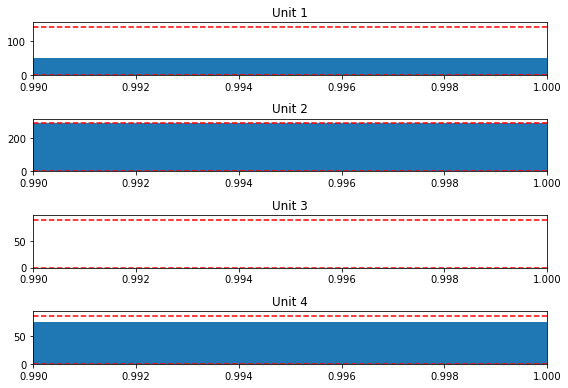

In [111]:
#Graph solution
fig, ax = plt.subplots(max(G)+1, 1, figsize=(8, 1.5*max(G)+1))
for g in G:
    ax[g].bar(1, [m.p[g]()])
    ax[g].set_xlim(0.99,1)
    ax[g].set_ylim(0, 1.1*PMax[g])
    ax[g].plot(ax[g].get_xlim(), np.array([PMax[g], PMax[g]]), 'r--')
    ax[g].plot(ax[g].get_xlim(), np.array([PMin[g], PMin[g]]), 'r--')
    ax[g].set_title('Unit ' + str(g+1))
fig.tight_layout()